This notebook is an overview of some of the operator combinations and inputs/outputs used in the DQ webpage bolo processing script a4-process_bolo_stats.py under the "scripts" subdir of the repository.

The goal is to do some light TOD processing, including calibration, NaN and turnaround gap filling, poly filtering full timestream and/or detrending subscans, first-pass glitch finding, downsampling TODs + plotting, and PSD estimation, fitting, and plotting. So far scan-synchronous signal estimation/filtering and WHWP signal estimation/filtering haven't been incorporated, but can be.

The relevant Operators themselves live in simons_array_python/sa_timestream_operators.py module. For kind of historical reasons, the OperatorTODBase class is actually in simons_array_python/sa_pipeline_filters.py module

In [1]:
# Import statements
from simons_array_python.sa_timestream_operators import * # this loads in many relevant modules in its namespace
from simons_array_python.sa_cuts import OperatorTODGlitchFinder

INFO: numpy.fft used.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20210205/pb2a_runid.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20210205/pb2a_runid_g3.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20210205/pb2a_data_quality.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20210205/pb2a_mapping.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20210205/pb2a_tuning.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20210205/pb2a_monitor.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20210205/pb2a_stim_template.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20210205/pb2a_stim.db attached.


In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
# Get bolo info; now comes in handy form from sa_timestream_ops
all_dets = gen_bolo_list(return_rns=False) # return_rns returns readout names which are not mapped to bolos, 
                                            # but may still be studied
    
# How many dets to load at once? How much memory to consume?
cache_size = 5

# this integer multiplies cache_size to generate starting index of bolo name in all_dets
min_ind = 350
#cache_step = len(all_dets)//cache_size
cache_step = 1 # load 1 set of 5 detectors beginning at index lo_bolo_index
lo_bolo_index = min_ind*cache_size
hi_bolo_index = (min_ind + cache_step)*cache_size

Reading SQL table pb2a_focalplane...done.


In [4]:
# Pick an observation (using known good obs_id (run_id, run_subid) combination)
observation_tuple = (20100841, 8) # "Jupiter partial fine map", lots of planet hits

# Load this observation
obs = sa_ob.Observation(observation_tuple)
obs.load_metadata()
        
# Setting things up for processing.
data_input = sa_pi.InputLevel0CachedByObsID(all_detectors=all_dets, n_per_cache=cache_size, load_g3=True, load_slowdaq=False,
                                            load_dets=True, load_hwp=False, load_gcp=True,
                                            ignore_faulty_frame=True, ts_rounding_error=1e+10, record_frame_time=False)

# N.B. ts_rounding_error is in fractions of a sample period between contiguous data frames in .g3 files. 
# This huge number forces it to load frames and concatenate even when they are separated by bolo data dropouts.
# I think Tylor has confirmed these dropouts are filled as NaNs which we have to deal with.

# Another N.B.: my current sa_config for processing these data look like:
# data_root = '/data/pb2/ChileData/'
# hardware_map_dir = 'hardware_maps/polarbear/PB2a/Chile_May2019_coherent/'
# hardware_map_commit_hash = 'fad26d0c1d0cd248de11dd3fabaa1d8fdbd79022'
# database_impl = ('sa_db_pb2a', '/data/pb2/ChileData/databases/pb2a-20210205/') # retrofit data WITH 
                                                                                # flexible mapping dbs to allow specifying 
                                                                                # hwm + previous dbs
# database_files = ('pb2a_runid', 'pb2a_runid_g3', 'pb2a_data_quality', 'pb2a_mapping', 'pb2a_tuning', 'pb2a_monitor',
#                   'pb2a_stim_template', 'pb2a_stim')

Reading SQL table pb2a_runid...done.


In [5]:
# define outputs for plots (including tar file)
PLOT_DIRECTORY = '/scratch/ktcrowley/sa_plots/tes_plot_testdir/tes_plots/20210215_nb_plots'
output_ff = PlotFileFactoryTarfile(PLOT_DIRECTORY)

# load data operator
operator_load_data = sa_pf.OperatorDataInitializer(data_input)

# Define some OperatorComposites to allow initial processing of encoder vectors, processing of TODs, and plotting of final data
operator_preprocess = sa_pf.OperatorComposite(OperatorSubscanRange(az_field_name='az_pos', prefix='', plot=False), # 'az_pos' is bolo-interpolated field
                                              sa_pf.OperatorTelescopeDataInterpolator(prefix='corrected_', keep_raw=False),
                                              sa_pf.OperatorScanCorrector('raw_scan_flag', 'raw_scan_flag', 'raw_antenna_time_mjd'),
                                              sa_pf.OperatorScanCorrector('raw_scan_flag', 'raw_az_pos', 'raw_antenna_time_mjd'))

operator_bolo_preprocess = sa_pf.OperatorComposite(#OperatorTODPolyFilter(deg=5),
                                                   OperatorTODFillTurnarounds(detrend_per_subscan=False),
                                                   sa_pf.OperatorRemoveTODMean())

operator_evaluate = sa_pf.OperatorComposite(OperatorTODEvalSpectrum(tod_attr='I', eval_attr_name='tes_spectra.raw_i',                                                                   
                                                                    plot_file_factory=output_ff,
                                                                    plot_file_suffix='I_spectrum_fillturn', 
                                                                    perform_fit=True, scan_mask_df=0.005),
                                            OperatorTODDownsample(ndownsample=40, subscan_downsample=5, # nan_fill currently here
                                                                  eval_attr_name='tes_tod_downsamp.raw_i',
                                                                  plot_file_factory=output_ff,
                                                                  plot_file_suffix='I_downsampled_fillturn'),
                                            sa_pf.OperatorApplyCalibrationFromDB())

In [6]:
# Useful data from scan_statistics db
# Load scan freq IF EXISTS IN SCAN STAT
try:
    scan_row = sa_sql.db_impl.scan_db[obs.obs_id]
    print('Scan frequency found: {0:.4} Hz'.format(scan_row.scan_freq))
    scan_freq = scan_row.scan_freq
except KeyError:
    #Dummy value for now
    print('Dummy scan frequency used: 0.05 Hz')
    scan_freq = 0.05 # Hz
        
setattr(obs, 'scan_freq', scan_freq)

# Enable smart looping over cache size
for i in range(min_ind, min_ind+cache_step):# single element list, will just run this once
    init_det_ind = i*cache_size
    if i < len(all_dets)//cache_size:
        final_det_ind = (i+1)*cache_size
    else:
        final_det_ind = len(all_dets)-1

    det_subset = all_dets[init_det_ind:final_det_ind]
    obs.detectors = det_subset
    
    # Load relevant .g3 file data, including bolos in det_subset and encoder data (if not already loaded)
    operator_load_data.filter_obs(obs)
    
    if i == min_ind:
        operator_preprocess.filter_obs(obs)

        # Getting length of observation from bolo_times now
        setattr(obs, 'len_sec', np.ptp(obs.tod_list[0].read_times())*3600.*24)
        
        # Make sure OperatorScanCorrector worked properly
        assert obs.tod_list[0].read('corrected_antenna_time_mjd').size == obs.tod_list[0].read('corrected_az_pos').size
        
    operator_bolo_preprocess.filter_obs(obs)

Reading SQL table pb2a_scan_stat...done.
Loading data from g3 files for run_id=20100841, run_subid=8 . . . 
Reading SQL table pb2a_runid_g3file...

Scan frequency found: 0.03116 Hz
INFO: instantiating g3 data buffer from None
conflicting key: (None, None, 'Run22300549_002.g3'), sidestepping
conflicting key: (None, None, 'Run22300549_002.g3'), sidestepping
conflicting key: (None, None, 'Run22300549_002.g3'), sidestepping
conflicting key: (None, None, 'Run22300549_002.g3'), sidestepping
conflicting key: (None, None, 'Run22300549_002.g3'), sidestepping
conflicting key: (None, None, 'Run22300549_002.g3'), sidestepping
conflicting key: (None, None, 'Run22300549_002.g3'), sidestepping
conflicting key: (None, None, 'Run22300549_002.g3'), sidestepping
conflicting key: (None, None, 'Run22300600_000.g3'), sidestepping
conflicting key: (None, None, 'Run22300600_000.g3'), sidestepping
conflicting key: (None, None, 'Run22300600_000.g3'), sidestepping
conflicting key: (None, None, 'Run22300600_000.g3'), sidestepping
conflicting key: (None, None, 'Run22300600_000.g3'), sidestepping
conflicting key: (None, None, 'Run22300600_000.g3'), sidesteppin

done.
Reading SQL table pb2a_g3file...done.


INFO: Run20100841.8: reading following files: Run20100841_000.g3,Run20100841_001.g3,Run20100841_002.g3,Run20100841_003.g3,Run20100841_004.g3,Run20100841_005.g3,Run20100841_006.g3,Run20100841_007.g3,Run20100841_008.g3,Run20100841_009.g3,Run20100841_010.g3.
INFO: Run20100841.8: frame (total, first, last)=(1229, 19, 1217).


Setting input name to data
['13.15_41.150T-I', '13.15_41.150T-Q', '13.15_41.150B-I', '13.15_41.150B-Q', '13.15_41.90T-I', '13.15_41.90T-Q', '13.15_41.90B-I', '13.15_41.90B-Q', '13.15_44.150T-I', '13.15_44.150T-Q']


INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorScanCorrector'>


NEW VECTOR LENGTHS! 572500 475517
NEW VECTOR LENGTHS! 572500 475517


INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorScanCorrector'>
INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorTelescopeDataInterpolator'>
INFO: Applying pipeline filter: <class 'simons_array_python.sa_cuts.OperatorSubscanRange'>
INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorRemoveTODMean'>
INFO: Applying pipeline filter: <class 'simons_array_python.sa_timestream_operators.OperatorTODFillTurnarounds'>


<IPython.core.display.Javascript object>


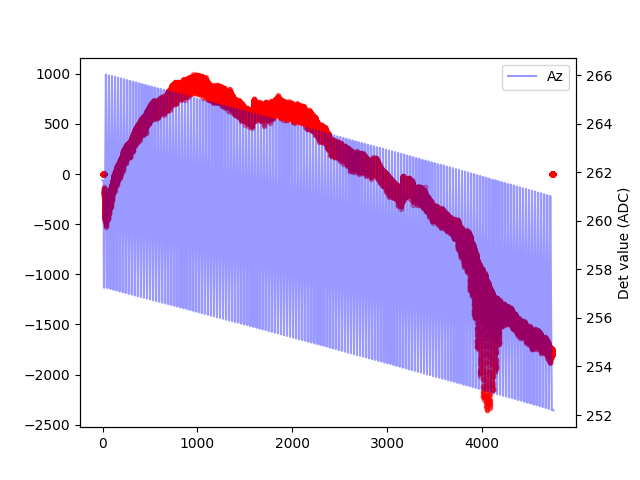

<IPython.core.display.Javascript object>


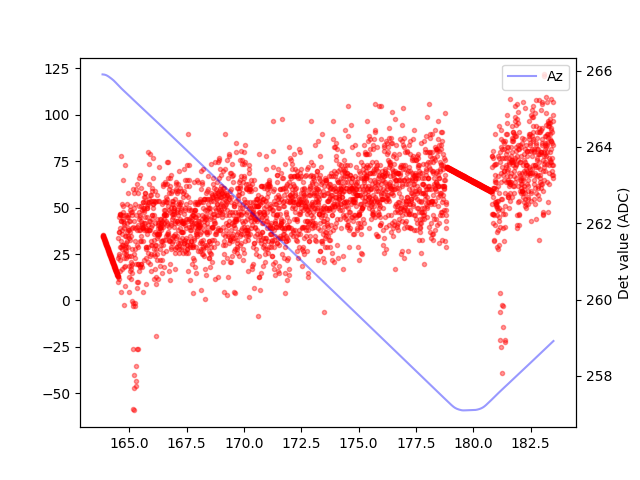

In [7]:
# Take one of the bolos and plot its resulting timestream
tod_arr = obs.tod_list[0].read('13.15_41.150B-I') # i know a priori that this bolo has a calibration factor to be applied!
bolo_times_relative = obs.tod_list[0].read_times()*3600.*24. # convert to s
bolo_times_relative += -1*bolo_times_relative[0]

plt.plot(bolo_times_relative, tod_arr, 'r.', label='13.15_41.150B-I', alpha=0.4)
ax = plt.twinx()
ax.plot(bolo_times_relative, np.rad2deg(obs.tod_list[0].read('az_pos')), 'b-', label='Az', alpha=0.4)
ax.set_ylabel('Azimuth position')
plt.xlabel('Time since start (s)')
plt.ylabel('Det value (ADC)')
plt.legend()

#Zoom in -- note linear interpolation at turnaround
plt.figure()
plt.plot(bolo_times_relative[25000:28000], tod_arr[25000:28000], 'r.', label='13.15_41.150B-I', alpha=0.4)
ax = plt.twinx()
ax.plot(bolo_times_relative[25000:28000], np.rad2deg(obs.tod_list[0].read('az_pos'))[25000:28000], 'b-', label='Az', alpha=0.4)
ax.set_ylabel('Azimuth position')
plt.xlabel('Time since start (s)')
plt.ylabel('Det value (ADC)')
plt.legend()

plt.show()

In [8]:
# Now work on glitch result operator

# This is currently the default kernel (used when kernel = None) but I've put it here to make clear how it works
example_triangle_kernel = np.zeros(tod_arr.size) 
midpoint = example_triangle_kernel.size//2 # make kernel symmetric around midpoint
# unit integral
example_triangle_kernel[midpoint-4:midpoint+5] = np.array([0.,1./16.,0.125,3./16.,0.25,3./16.,0.125,1./16.,0.])

# This kernel is then convolved with a HPF version of a bolo TOD, and a threshold cut 
# as function of std dev of HPF+convolved timestream is used to determine which samples
# are sufficiently high deviation from smooth changes in TOD to be glitches
# part of this threshold depends on width of kernel, etc.
op_glitch = OperatorTODGlitchFinder(kernel=example_triangle_kernel, 
                                    plot_only=['glitch.raw_i'], # this must equal eval_attr_name to produce plots
                                    sigma_threshold = 6., # default
                                    eval_attr_name='glitch.raw_i', fill_glitch=False)
# A band of data the size of the nonzero kernel + 2*an extra cut width is used to fill samples

<IPython.core.display.Javascript object>


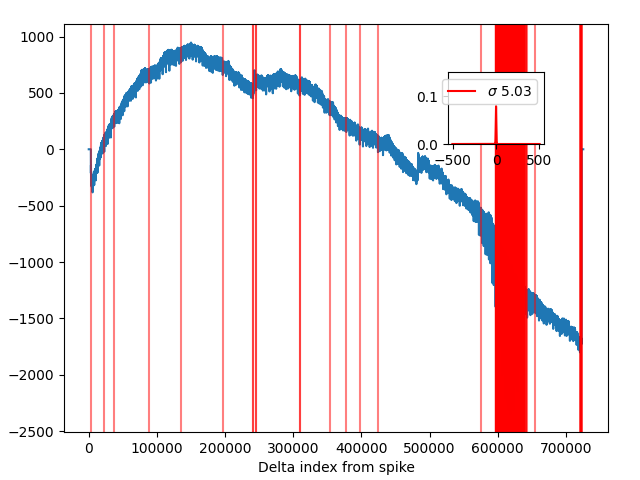

<IPython.core.display.Javascript object>


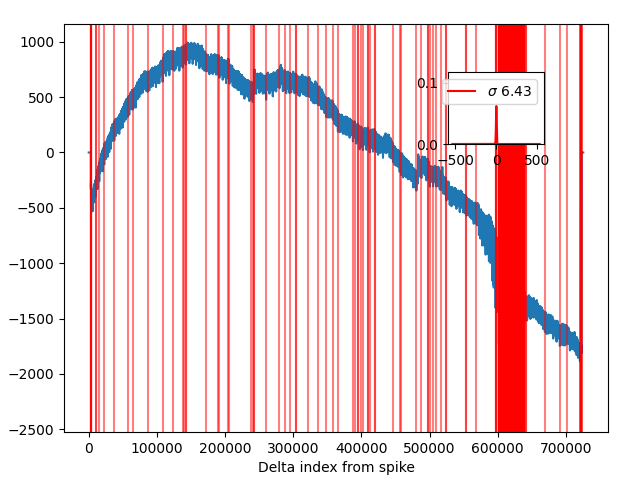

<IPython.core.display.Javascript object>


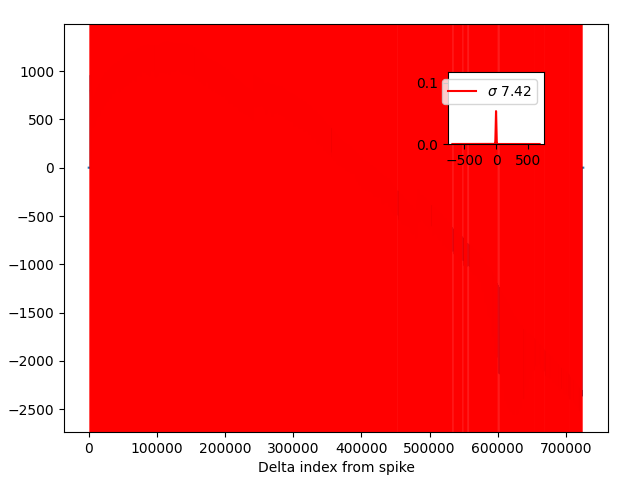

<IPython.core.display.Javascript object>


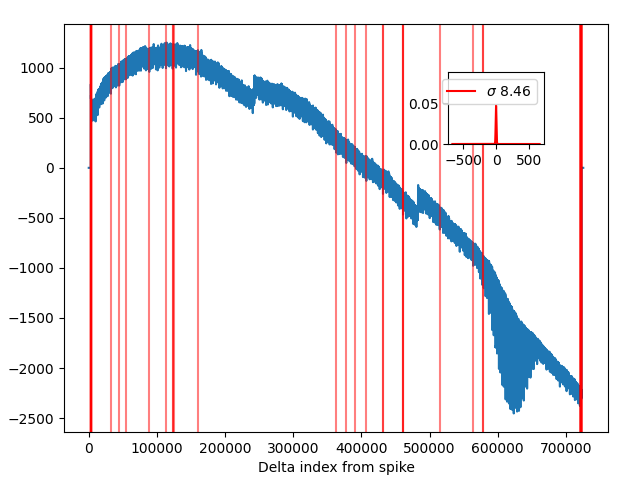

<IPython.core.display.Javascript object>


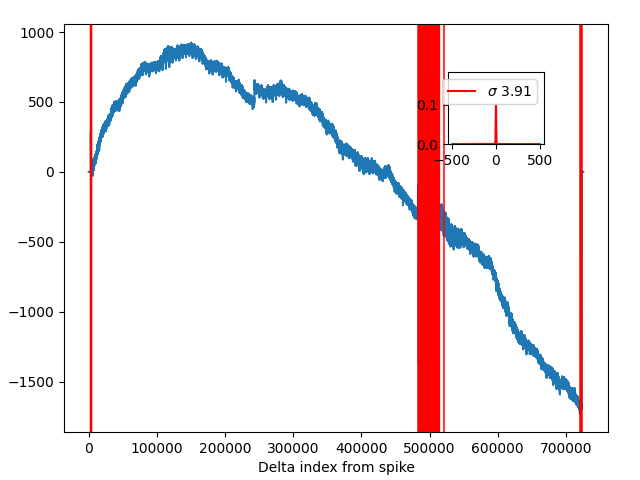

INFO: defining new eval attribute glitch.raw_i


In [9]:
op_glitch.filter_obs(obs)
plt.show()

dict_keys(['samples_above_glitch_threshold', 'nsig_threshold', 'convolve_sigma'])
# of glitch indices 4042 # of samples in TOD 725525


<IPython.core.display.Javascript object>


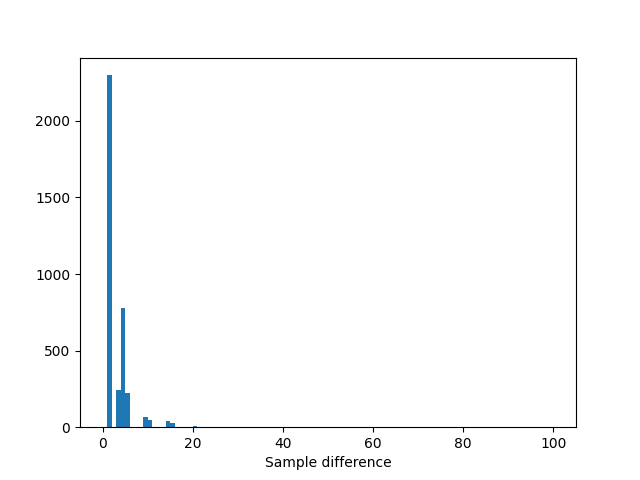

In [10]:
weirdbolo = '13.15_41.90T' # this is the bolometer with ~6-7x as many glitches found as other bolos

# Work with glitches
glitch_information = getattr(obs.tod_list[0], 'glitch.raw_i')
glitch_information_weirdbolo = glitch_information[weirdbolo]
print(glitch_information_weirdbolo.keys())

weirdbolo_tod_arr = obs.tod_list[0].read(weirdbolo+'-I')
possible_glitches = glitch_information_weirdbolo['samples_above_glitch_threshold']

print('# of glitch indices', possible_glitches.size, '# of samples in TOD', weirdbolo_tod_arr.size)

# Histogram of distance between glitches
plt.figure()
plt.hist(np.diff(possible_glitches), bins=100, range=(0, 100))
plt.xlabel('Sample difference')
plt.show() # Most glitches are next to each other -- multiple samples wide
# Filling method in OpGlitchFinder accounts for this 

<IPython.core.display.Javascript object>


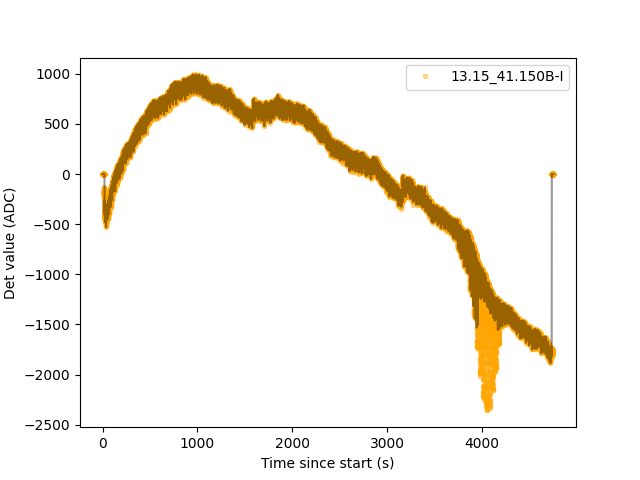

In [8]:
#tod_arr_raw = np.copy(obs.tod_list[0].read('13.15_41.150B-I'))
#bolo_times_relative = obs.tod_list[0].read_times()*3600.*24. # convert to s
#bolo_times_relative += -1*bolo_times_relative[0]

# Replot the timestream of the soon-to-be calibrated bolo
plt.figure()
plt.plot(bolo_times_relative, tod_arr_raw, '.', color='orange', label='13.15_41.150B-I', alpha=0.4)
plt.xlabel('Time since start (s)')
plt.ylabel('Det value (ADC)')

# Use glitch finder, which will fill glitches for this bolometer
#op_glitch_fill = OperatorTODGlitchFinder(plot_only=[], eval_attr_name='glitch.raw_i', fill_glitch=True)
#op_glitch_fill.filter_obs(obs)

tod_arr_glitchfilled = obs.tod_list[0].read('13.15_41.150B-I')
plt.plot(bolo_times_relative, tod_arr_glitchfilled, 'k-', alpha=0.4)
plt.legend()
plt.show()

In [9]:
# For completeness, run calibration and plotting operators
operator_evaluate.filter_obs(obs)

INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorApplyCalibrationFromDB'>
INFO: Applying pipeline filter: <class 'simons_array_python.sa_timestream_operators.OperatorTODDownsample'>


INFO: Looking for NaNs, found 0
nans gone? 0
INFO: Looking for NaNs, found 0
nans gone? 0


wrote 20100841.8/pb2a_13.15_41.150B_unfilter_I_downsampled_fillturn.png


INFO: Looking for NaNs, found 0
nans gone? 0
INFO: Looking for NaNs, found 0
nans gone? 0
INFO: Looking for NaNs, found 0
nans gone? 0


wrote 20100841.8/pb2a_13.15_44.150T_unfilter_I_downsampled_fillturn.png
INFO: Applying pipeline filter: <class 'simons_array_python.sa_timestream_operators.OperatorTODEvalSpectrum'>


INFO: defining new eval attribute tes_tod_downsamp.raw_i
INFO: looking for TES 13.15_41.150T
INFO: Looking for NaNs, found 0
nans gone? 0


/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:388: RuntimeWarning: invalid value encountered in double_scalars
  fknee_initial = (B/A)**(1./s)
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:321: RuntimeWarning: invalid value encountered in true_divide
  bin_frac_increase = bin_est/self.binned_pk
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:344: RuntimeWarning: invalid value encountered in less
  possible_spikes = np.where((bin_frac_increase < (1. - (WN_SCALE*wn_std))) & (self.binned_k > 0.1))[0]
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:223: RuntimeWarning: divide by zero encountered in log
  logl = np.log(model_pk) + self.binned_pk/model_pk
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:223: RuntimeWarning: invalid value encountered in true_divide
  l

INFO: looking for TES 13.15_41.150B
INFO: Looking for NaNs, found 0
nans gone? 0


wrote 20100841.8/pb2a_13.15_41.150B_unfilter_I_spectrum_fillturn.png
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:388: RuntimeWarning: invalid value encountered in double_scalars
  fknee_initial = (B/A)**(1./s)
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:321: RuntimeWarning: invalid value encountered in true_divide
  bin_frac_increase = bin_est/self.binned_pk
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:344: RuntimeWarning: invalid value encountered in less
  possible_spikes = np.where((bin_frac_increase < (1. - (WN_SCALE*wn_std))) & (self.binned_k > 0.1))[0]
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:223: RuntimeWarning: divide by zero encountered in log
  logl = np.log(model_pk) + self.binned_pk/model_pk
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators

INFO: looking for TES 13.15_41.90T
INFO: Looking for NaNs, found 0
nans gone? 0
INFO: looking for TES 13.15_41.90B
INFO: Looking for NaNs, found 0
nans gone? 0


INFO: looking for TES 13.15_44.150T
INFO: Looking for NaNs, found 0
nans gone? 0
INFO: defining new eval attribute tes_spectra.raw_i


wrote 20100841.8/pb2a_13.15_44.150T_unfilter_I_spectrum_fillturn.png
